# Fancy Indexing

## Fancy Indexingを探る
Fancy indexingのコンセプトはシンプルである。つまり、複数のarrayの要素を一度にアクセスするためにarrayのインデックスを渡すということである。

In [1]:
import numpy as np
rand = np.random.RandomState(42)

x = rand.randint(100, size=10)
print(x)

[51 92 14 71 60 20 82 86 74 74]


In [2]:
[x[3], x[7], x[2]]

[71, 86, 14]

In [3]:
ind = [3, 7, 2]
x[ind]

array([71, 86, 14])

Fancy indexingを使用する時、結果として得られる形状は、インデックスされたarrayの形状ではなく、index arrayの形状を反映する。

In [4]:
ind = np.array([[3, 7],
                 [4, 5]])
x[ind]

array([[71, 86],
       [60, 20]])

Fancy indexingは多次元でも動作する。以下のようなarrayを考える。

In [5]:
X = np.arange(12).reshape((3, 4))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [6]:
row = np.array([0, 1, 2])
col = np.array([2, 1, 3])
X[row, col]

array([ 2,  5, 11])

fancy indexingにおいてインデックスのペアはすべてブロードキャストルールに則る。

In [7]:
X[row[:, np.newaxis], col]

array([[ 2,  1,  3],
       [ 6,  5,  7],
       [10,  9, 11]])

上記の例では、

- `row.shape = (3, 1)`
- `col.shape = (3,)`

から

- `row.shape -> (3, 1)`
- `col.shape -> (1, 3)`

そして、

- `row.shape -> (3, 3)`
- `col.shape -> (3, 3)`

となっており結果として

```
02, 01, 03
12, 11, 13
22, 21, 23
```

の要素が返される。

## インデックスの結合

In [8]:
print(X)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


In [9]:
X[2, [2, 0, 1]]

array([10,  8,  9])

fancy indexingをスライスと合わせて利用することも出来る。

In [10]:
X[1:, [2, 0, 1]]

array([[ 6,  4,  5],
       [10,  8,  9]])

maskと合わせて利用することも可能。

In [11]:
mask = np.array([1, 0, 1, 0], dtype=bool)
X[row[:, np.newaxis], mask]

array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])

## 例：ランダムなポイントの選択
2次元に正規分布する点を、平均（mean）と共分散（cov）から取得する。

In [12]:
mean = [0, 0]
cov = [[1, 2],
        [2, 5]]
X = rand.multivariate_normal(mean, cov, 100)
X.shape

(100, 2)

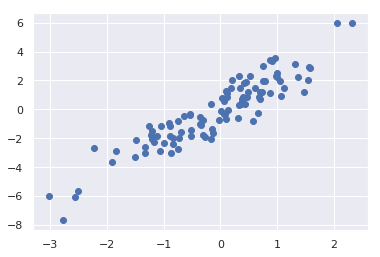

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling

plt.scatter(X[:, 0], X[:, 1]);

20個のランダムなポイントを抜き出すために、20個のランダムなインデックスのarrayを作成する。

In [14]:
indices = np.random.choice(X.shape[0], 20, replace=False)
indices

array([ 3, 70, 10, 37, 30, 60, 11, 80, 21, 43, 98, 14,  2,  7, 69, 32, 33,
       84, 39, 44])

In [15]:
selection = X[indices]
selection.shape

(20, 2)

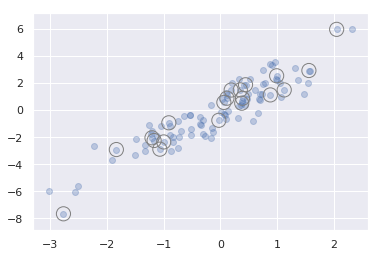

In [16]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
plt.scatter(selection[:, 0], selection[:, 1],
            facecolor='none', edgecolor='gray', s=200);

## Facny Indexingを利用して値を修正する

In [17]:
x = np.arange(10)
i = np.array([2, 1, 8, 4])
x[i] = 99
print(x)

[ 0 99 99  3 99  5  6  7 99  9]


In [18]:
x[i] -= 10
print(x)

[ 0 89 89  3 89  5  6  7 89  9]


繰り返し選択されてインデックスに対しては思いもよらない結果を招く。例えば、以下では始めに、`x[0] = 4`が実行され、そのあと`x[0] = 6`が実行される。

In [19]:
x = np.zeros(10)
x[[0, 0]] = [4, 6]
print(x)

[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


下記も似たような例である。ここでは`x[3]`が2、`x[4]`が3となることが期待されるが、実際はそうはなっていない。これは`x[i] += 1`が`x[i] = x[i] +1`の省略であるからである。この操作では、始めに`x[i] + 1`が行われる。つまり、`x`のインデックスに対しては最終的な結果のみが格納されるため、期待される結果が得られない。

In [20]:
i = [2, 3, 3, 4, 4, 4]
x[i] += 1
x

array([6., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

もし、上記のようなことをやりたければ`at()`を利用する。

In [21]:
x = np.zeros(10)
np.add.at(x, i, 1)
print(x)

[0. 0. 1. 2. 3. 0. 0. 0. 0. 0.]


## 例：データのBinning
例えば、1000個の値を持っていて、どのビンのarrayに属するか簡単に見つけたいとする。それは`ufunc.at`を利用して行える。

以下の例では、始めに100個のランダムなarrayを生成し、(-5,5)の間を20等分したビンを用意している。

`searchshorted`はarrayの値がどのインデックスの間に入るかどうかをそのインデックスで返す。

その後、`at()`を利用して、インデックスの数だけ足し合わせている。

In [22]:
np.random.seed(42)
x = np.random.randn(100)

# compute a histgram by hand
bins = np.linspace(-5, 5, 20)

# find the appropriate bin for each x
i = np.searchsorted(bins, x)

# add 1 to each of these bins
counts = np.zeros_like(bins)
np.add.at(counts, i, 1)

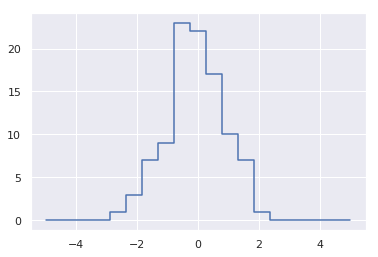

In [23]:
# plot the results
plt.plot(bins, counts, linestyle='steps');

もちろん、こんなバカげたことをヒストグラムを書く度にやっていられないので、Matplotlibは`plt.hist()`を提供している。

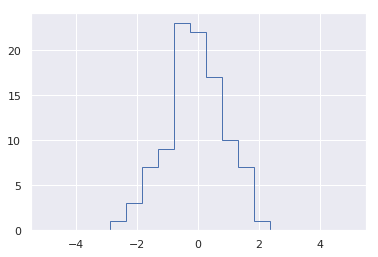

In [24]:
plt.hist(x, bins, histtype='step');

処理速度に関しては、データ量が少ない場合はカスタムしたものの方が早い。しかし、データ量が多くなってくると、Matplotlib組み込みの処理の方が早くなってくる。